In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt

### Download data from kaggle

In [2]:
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")
TARGET_BLOCKS_DATADIR = os.path.join(path,'hhblock_dataset/hhblock_dataset')
blocks_csv_files = [
        os.path.join(TARGET_BLOCKS_DATADIR, csv_path)
        for csv_path in filter(
            lambda path:
            path.endswith('.csv'),
            os.listdir(TARGET_BLOCKS_DATADIR))
    ]

100%|██████████| 1.17G/1.17G [00:20<00:00, 60.3MB/s]

Extracting files...


### Choose the block name and print it

In [3]:
idx = 99
path_specified=f"{TARGET_BLOCKS_DATADIR}/block_{idx}.csv"
block = pd.read_csv(path_specified, encoding='latin', parse_dates=['day'], date_format='%Y-%m-%d')
block.head(5)

LCLid        day   hh_0   hh_1   hh_2   hh_3   hh_4   hh_5   hh_6  \
0  MAC000231 2011-12-02  0.076  0.064  0.005  0.000  0.061  0.009  0.000   
1  MAC000231 2011-12-03  0.000  0.033  0.048  0.000  0.011  0.055  0.007   
2  MAC000231 2011-12-04  0.046  0.023  0.000  0.055  0.209  0.036  0.053   
3  MAC000231 2011-12-05  0.000  0.062  0.002  0.016  0.045  0.000  0.035   
4  MAC000231 2011-12-06  0.039  0.030  0.000  0.036  0.033  0.000  0.028   

    hh_7  ...  hh_38  hh_39  hh_40  hh_41  hh_42  hh_43  hh_44  hh_45  hh_46  \
0  0.051  ...  0.052  0.103  0.210  0.062  0.065  0.109  0.048  0.520  0.646   
1  0.018  ...  0.000  0.422  0.510  0.085  0.146  0.484  0.135  0.310  0.105   
2  0.001  ...  0.088  0.293  0.306  0.111  0.278  0.614  0.723  0.176  0.101   
3  0.027  ...  0.069  0.719  0.637  0.625  0.652  0.313  0.593  0.766  0.299   
4  0.040  ...  0.094  0.082  0.106  0.047  0.058  0.567  0.616  0.529  0.112   

   hh_47  
0  0.052  
1  0.068  
2  0.155  
3  0.000  
4  0.006  

[5 rows x 50 columns]

### This function is used to fill the gaps between days (missing days)

In [4]:
def convert_consumer_to_standard_form(consumer_data, consumer_id, verbose=False):
  start_date = consumer_data['day'].min()
  end_date = consumer_data['day'].max()
  standrad_df = pd.DataFrame()
  standrad_df['day'] = pd.date_range(start=start_date, end=end_date, freq='1D')
  standard_df  = standrad_df.merge(consumer_data, on=['day'], how='left')
  return standard_df

### This function used to convert data to time series data by frequency 30 min (48 read by day)

In [5]:
def convert_standard_form_to_expand_time_series(standard_df, consumer_id,  verbose=False):
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
  expand_df['frequency'] = '30min'
  expand_df['serie_length'] = len(expand_df)
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  expand_df = expand_df.drop(columns=['day','offset'])
  expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  return expand_df

In [6]:
block

LCLid        day   hh_0   hh_1   hh_2   hh_3   hh_4   hh_5   hh_6  \
0      MAC000231 2011-12-02  0.076  0.064  0.005  0.000  0.061  0.009  0.000   
1      MAC000231 2011-12-03  0.000  0.033  0.048  0.000  0.011  0.055  0.007   
2      MAC000231 2011-12-04  0.046  0.023  0.000  0.055  0.209  0.036  0.053   
3      MAC000231 2011-12-05  0.000  0.062  0.002  0.016  0.045  0.000  0.035   
4      MAC000231 2011-12-06  0.039  0.030  0.000  0.036  0.033  0.000  0.028   
...          ...        ...    ...    ...    ...    ...    ...    ...    ...   
33220  MAC005019 2014-02-23  0.212  0.170  0.145  0.228  0.123  0.081  0.130   
33221  MAC005019 2014-02-24  0.064  0.107  0.107  0.122  0.095  0.132  0.085   
33222  MAC005019 2014-02-25  0.053  0.067  0.060  0.076  0.051  0.070  0.033   
33223  MAC005019 2014-02-26  0.045  0.049  0.077  0.032  0.051  0.065  0.042   
33224  MAC005019 2014-02-27  0.057  0.040  0.095  0.029  0.033  0.049  0.067   

        hh_7  ...  hh_38  hh_39  hh_40  hh_41  hh_42  hh_43  hh_44  hh_45  \
0      0.051  ...  0.052  0.103  0.210  0.062  0.065  0.109  0.048  0.520   
1      0.018  ...  0.000  0.422  0.510  0.085  0.146  0.484  0.135  0.310   
2      0.001  ...  0.088  0.293  0.306  0.111  0.278  0.614  0.723  0.176   
3      0.027  ...  0.069  0.719  0.637  0.625  0.652  0.313  0.593  0.766   
4      0.040  ...  0.094  0.082  0.106  0.047  0.058  0.567  0.616  0.529   
...      ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
33220  0.079  ...  0.092  0.102  0.081  0.111  0.072  0.135  0.116  0.133   
33221  0.137  ...  0.103  0.106  0.103  0.099  0.072  0.097  0.057  0.088   
33222  0.061  ...  0.805  1.235  1.243  1.150  0.547  0.418  0.125  0.076   
33223  0.039  ...  0.480  0.271  0.214  0.149  0.116  0.165  0.058  0.060   
33224  0.047  ...  0.167  0.250  0.449  0.195  0.122  0.154  0.129  0.095   

       hh_46  hh_47  
0      0.646  0.052  
1      0.105  0.068  
2      0.101  0.155  
3      0.299  0.000  
4      0.112  0.006  
...      ...    ...  
33220  0.092  0.067  
33221  0.046  0.077  
33222  0.041  0.090  
33223  0.077  0.045  
33224  0.061  0.054  

[33225 rows x 50 columns]

In [7]:
result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)
result

<ipython-input-7-35de716bdf25>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)


day      LCLid   hh_0   hh_1   hh_2   hh_3   hh_4   hh_5   hh_6  \
0     2011-12-02  MAC000231  0.076  0.064  0.005  0.000  0.061  0.009  0.000   
1     2011-12-03  MAC000231  0.000  0.033  0.048  0.000  0.011  0.055  0.007   
2     2011-12-04  MAC000231  0.046  0.023  0.000  0.055  0.209  0.036  0.053   
3     2011-12-05  MAC000231  0.000  0.062  0.002  0.016  0.045  0.000  0.035   
4     2011-12-06  MAC000231  0.039  0.030  0.000  0.036  0.033  0.000  0.028   
...          ...        ...    ...    ...    ...    ...    ...    ...    ...   
33446 2014-02-23  MAC005019  0.212  0.170  0.145  0.228  0.123  0.081  0.130   
33447 2014-02-24  MAC005019  0.064  0.107  0.107  0.122  0.095  0.132  0.085   
33448 2014-02-25  MAC005019  0.053  0.067  0.060  0.076  0.051  0.070  0.033   
33449 2014-02-26  MAC005019  0.045  0.049  0.077  0.032  0.051  0.065  0.042   
33450 2014-02-27  MAC005019  0.057  0.040  0.095  0.029  0.033  0.049  0.067   

        hh_7  ...  hh_38  hh_39  hh_40  hh_41  hh_42  hh_43  hh_44  hh_45  \
0      0.051  ...  0.052  0.103  0.210  0.062  0.065  0.109  0.048  0.520   
1      0.018  ...  0.000  0.422  0.510  0.085  0.146  0.484  0.135  0.310   
2      0.001  ...  0.088  0.293  0.306  0.111  0.278  0.614  0.723  0.176   
3      0.027  ...  0.069  0.719  0.637  0.625  0.652  0.313  0.593  0.766   
4      0.040  ...  0.094  0.082  0.106  0.047  0.058  0.567  0.616  0.529   
...      ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
33446  0.079  ...  0.092  0.102  0.081  0.111  0.072  0.135  0.116  0.133   
33447  0.137  ...  0.103  0.106  0.103  0.099  0.072  0.097  0.057  0.088   
33448  0.061  ...  0.805  1.235  1.243  1.150  0.547  0.418  0.125  0.076   
33449  0.039  ...  0.480  0.271  0.214  0.149  0.116  0.165  0.058  0.060   
33450  0.047  ...  0.167  0.250  0.449  0.195  0.122  0.154  0.129  0.095   

       hh_46  hh_47  
0      0.646  0.052  
1      0.105  0.068  
2      0.101  0.155  
3      0.299  0.000  
4      0.112  0.006  
...      ...    ...  
33446  0.092  0.067  
33447  0.046  0.077  
33448  0.041  0.090  
33449  0.077  0.045  
33450  0.061  0.054  

[33451 rows x 50 columns]

In [8]:
expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()
expand_form

<ipython-input-8-c6c5c428ad93>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()


LCLid           timestamp  energy_consumption frequency  \
0        MAC000231 2011-12-02 00:00:00               0.076     30min   
1        MAC000231 2011-12-02 00:30:00               0.064     30min   
2        MAC000231 2011-12-02 01:00:00               0.005     30min   
3        MAC000231 2011-12-02 01:30:00               0.000     30min   
4        MAC000231 2011-12-02 02:00:00               0.061     30min   
...            ...                 ...                 ...       ...   
1594795  MAC005019 2014-02-20 21:30:00               0.154     30min   
1594796  MAC005019 2014-02-20 22:00:00               0.129     30min   
1594797  MAC005019 2014-02-20 22:30:00               0.095     30min   
1594798  MAC005019 2014-02-20 23:00:00               0.061     30min   
1594799  MAC005019 2014-02-20 23:30:00               0.054     30min   

         serie_length  
0               38880  
1               38880  
2               38880  
3               38880  
4               38880  
...               ...  
1594795         30720  
1594796         30720  
1594797         30720  
1594798         30720  
1594799         30720  

[1594800 rows x 5 columns]

In [9]:
expand_form["energy_consumption"].isna().sum()

np.int64(50)

 - use specific LCLid (consumer) and visualize its reads with time (TimeSeries Analysis)
 - interplolate (impute) the NAN values in the Energy Consumption col

In [10]:
ts_df = expand_form[expand_form.LCLid=="MAC005019"].set_index("timestamp")
ts_df['energy_consumption'] = ts_df['energy_consumption'].interpolate(method='polynomial',order=3)

In [11]:
ts_df

LCLid  energy_consumption frequency  serie_length
timestamp                                                                 
2012-05-22 00:00:00  MAC005019               0.101     30min         30720
2012-05-22 00:30:00  MAC005019               0.110     30min         30720
2012-05-22 01:00:00  MAC005019               0.078     30min         30720
2012-05-22 01:30:00  MAC005019               0.063     30min         30720
2012-05-22 02:00:00  MAC005019               0.109     30min         30720
...                        ...                 ...       ...           ...
2014-02-20 21:30:00  MAC005019               0.154     30min         30720
2014-02-20 22:00:00  MAC005019               0.129     30min         30720
2014-02-20 22:30:00  MAC005019               0.095     30min         30720
2014-02-20 23:00:00  MAC005019               0.061     30min         30720
2014-02-20 23:30:00  MAC005019               0.054     30min         30720

[30720 rows x 4 columns]

In [12]:
ts_df["energy_consumption"].isna().sum()

np.int64(0)

### Add some properities to use in visualizations and analysis


In [13]:
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["hour"] = ts_df.index.hour
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year

In [14]:
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [15]:
ts_df

LCLid  energy_consumption frequency  serie_length  \
timestamp                                                                    
2012-05-22 00:00:00  MAC005019               0.101     30min         30720   
2012-05-22 00:30:00  MAC005019               0.110     30min         30720   
2012-05-22 01:00:00  MAC005019               0.078     30min         30720   
2012-05-22 01:30:00  MAC005019               0.063     30min         30720   
2012-05-22 02:00:00  MAC005019               0.109     30min         30720   
...                        ...                 ...       ...           ...   
2014-02-20 21:30:00  MAC005019               0.154     30min         30720   
2014-02-20 22:00:00  MAC005019               0.129     30min         30720   
2014-02-20 22:30:00  MAC005019               0.095     30min         30720   
2014-02-20 23:00:00  MAC005019               0.061     30min         30720   
2014-02-20 23:30:00  MAC005019               0.054     30min         30720   

                    weekday_name  weekday  week  day  hour        date  month  \
timestamp                                                                       
2012-05-22 00:00:00      Tuesday        1    21   22     0  2012-05-22      5   
2012-05-22 00:30:00      Tuesday        1    21   22     0  2012-05-22      5   
2012-05-22 01:00:00      Tuesday        1    21   22     1  2012-05-22      5   
2012-05-22 01:30:00      Tuesday        1    21   22     1  2012-05-22      5   
2012-05-22 02:00:00      Tuesday        1    21   22     2  2012-05-22      5   
...                          ...      ...   ...  ...   ...         ...    ...   
2014-02-20 21:30:00     Thursday        3     8   20    21  2014-02-20      2   
2014-02-20 22:00:00     Thursday        3     8   20    22  2014-02-20      2   
2014-02-20 22:30:00     Thursday        3     8   20    22  2014-02-20      2   
2014-02-20 23:00:00     Thursday        3     8   20    23  2014-02-20      2   
2014-02-20 23:30:00     Thursday        3     8   20    23  2014-02-20      2   

                    month_name  year  
timestamp                             
2012-05-22 00:00:00        May  2012  
2012-05-22 00:30:00        May  2012  
2012-05-22 01:00:00        May  2012  
2012-05-22 01:30:00        May  2012  
2012-05-22 02:00:00        May  2012  
...                        ...   ...  
2014-02-20 21:30:00   February  2014  
2014-02-20 22:00:00   February  2014  
2014-02-20 22:30:00   February  2014  
2014-02-20 23:00:00   February  2014  
2014-02-20 23:30:00   February  2014  

[30720 rows x 13 columns]

In [16]:
hourly_df = ts_df.groupby(["year","month","week","day","hour"])[['energy_consumption']].mean()
hourly_df

energy_consumption
year month week day hour                    
2012 5     21   22  0                 0.1055
                    1                 0.0705
                    2                 0.0945
                    3                 0.0815
                    4                 0.0780
...                                      ...
2014 2     8    20  19                0.2085
                    20                0.3220
                    21                0.1380
                    22                0.1120
                    23                0.0575

[15360 rows x 1 columns]

In [17]:
hourly_df = hourly_df.reset_index()
hourly_df['timestamp'] = hourly_df.apply(
    lambda row: pd.Timestamp(
        year=int(row['year']),
        month=int(row['month']),
        day=int(row['day']),
        hour=int(row['hour'])
    ),
    axis=1
)

hourly_df = hourly_df.set_index('timestamp').sort_index()
hourly_df

year  month  week  day  hour  energy_consumption
timestamp                                                            
2012-05-22 00:00:00  2012      5    21   22     0              0.1055
2012-05-22 01:00:00  2012      5    21   22     1              0.0705
2012-05-22 02:00:00  2012      5    21   22     2              0.0945
2012-05-22 03:00:00  2012      5    21   22     3              0.0815
2012-05-22 04:00:00  2012      5    21   22     4              0.0780
...                   ...    ...   ...  ...   ...                 ...
2014-02-20 19:00:00  2014      2     8   20    19              0.2085
2014-02-20 20:00:00  2014      2     8   20    20              0.3220
2014-02-20 21:00:00  2014      2     8   20    21              0.1380
2014-02-20 22:00:00  2014      2     8   20    22              0.1120
2014-02-20 23:00:00  2014      2     8   20    23              0.0575

[15360 rows x 6 columns]

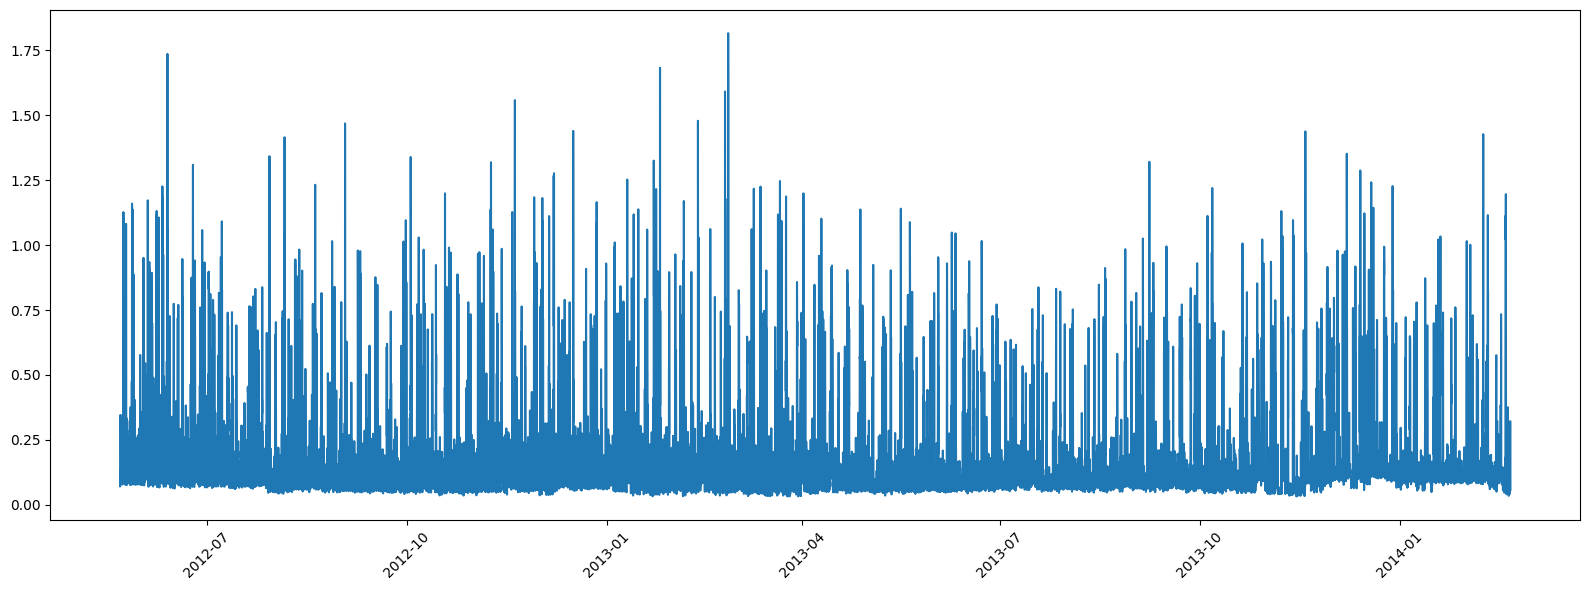

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(hourly_df.index, hourly_df["energy_consumption"])

plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

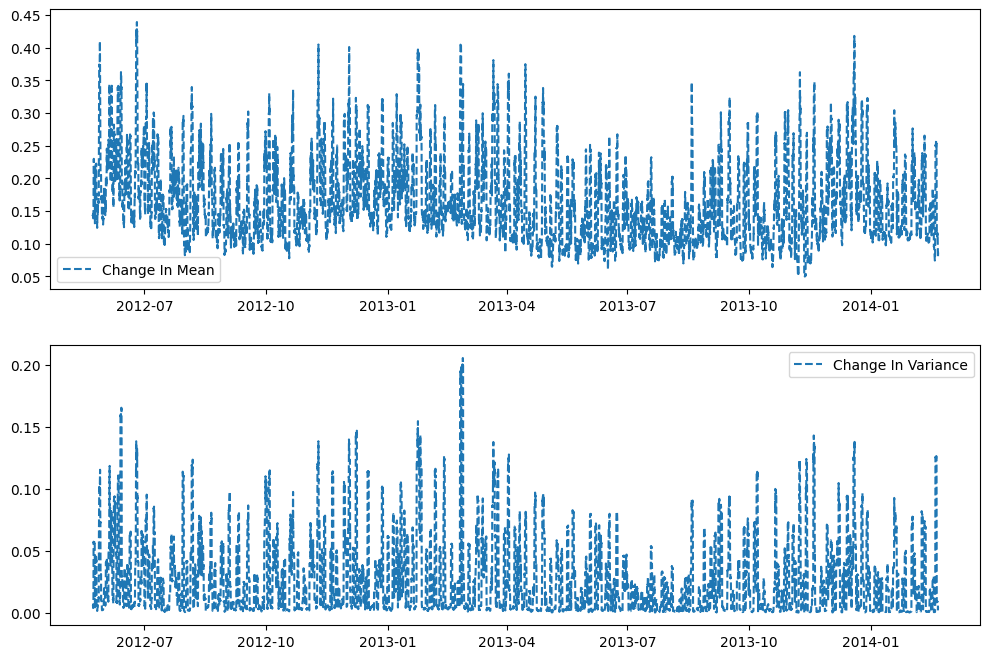

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(hourly_df.index, hourly_df['energy_consumption'].rolling(window=24).mean() , label='Change In Mean', linestyle='--')
ax[1].plot(hourly_df.index, hourly_df['energy_consumption'].rolling(window=24).var() , label='Change In Variance', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

### There is change in mean and in variance so i will log variance and also i will decompose data to get the trend (change in mean) and aslo seasonality

In [20]:
import numpy as np
hourly_df['log_energy_consumption'] = np.log(hourly_df['energy_consumption'])

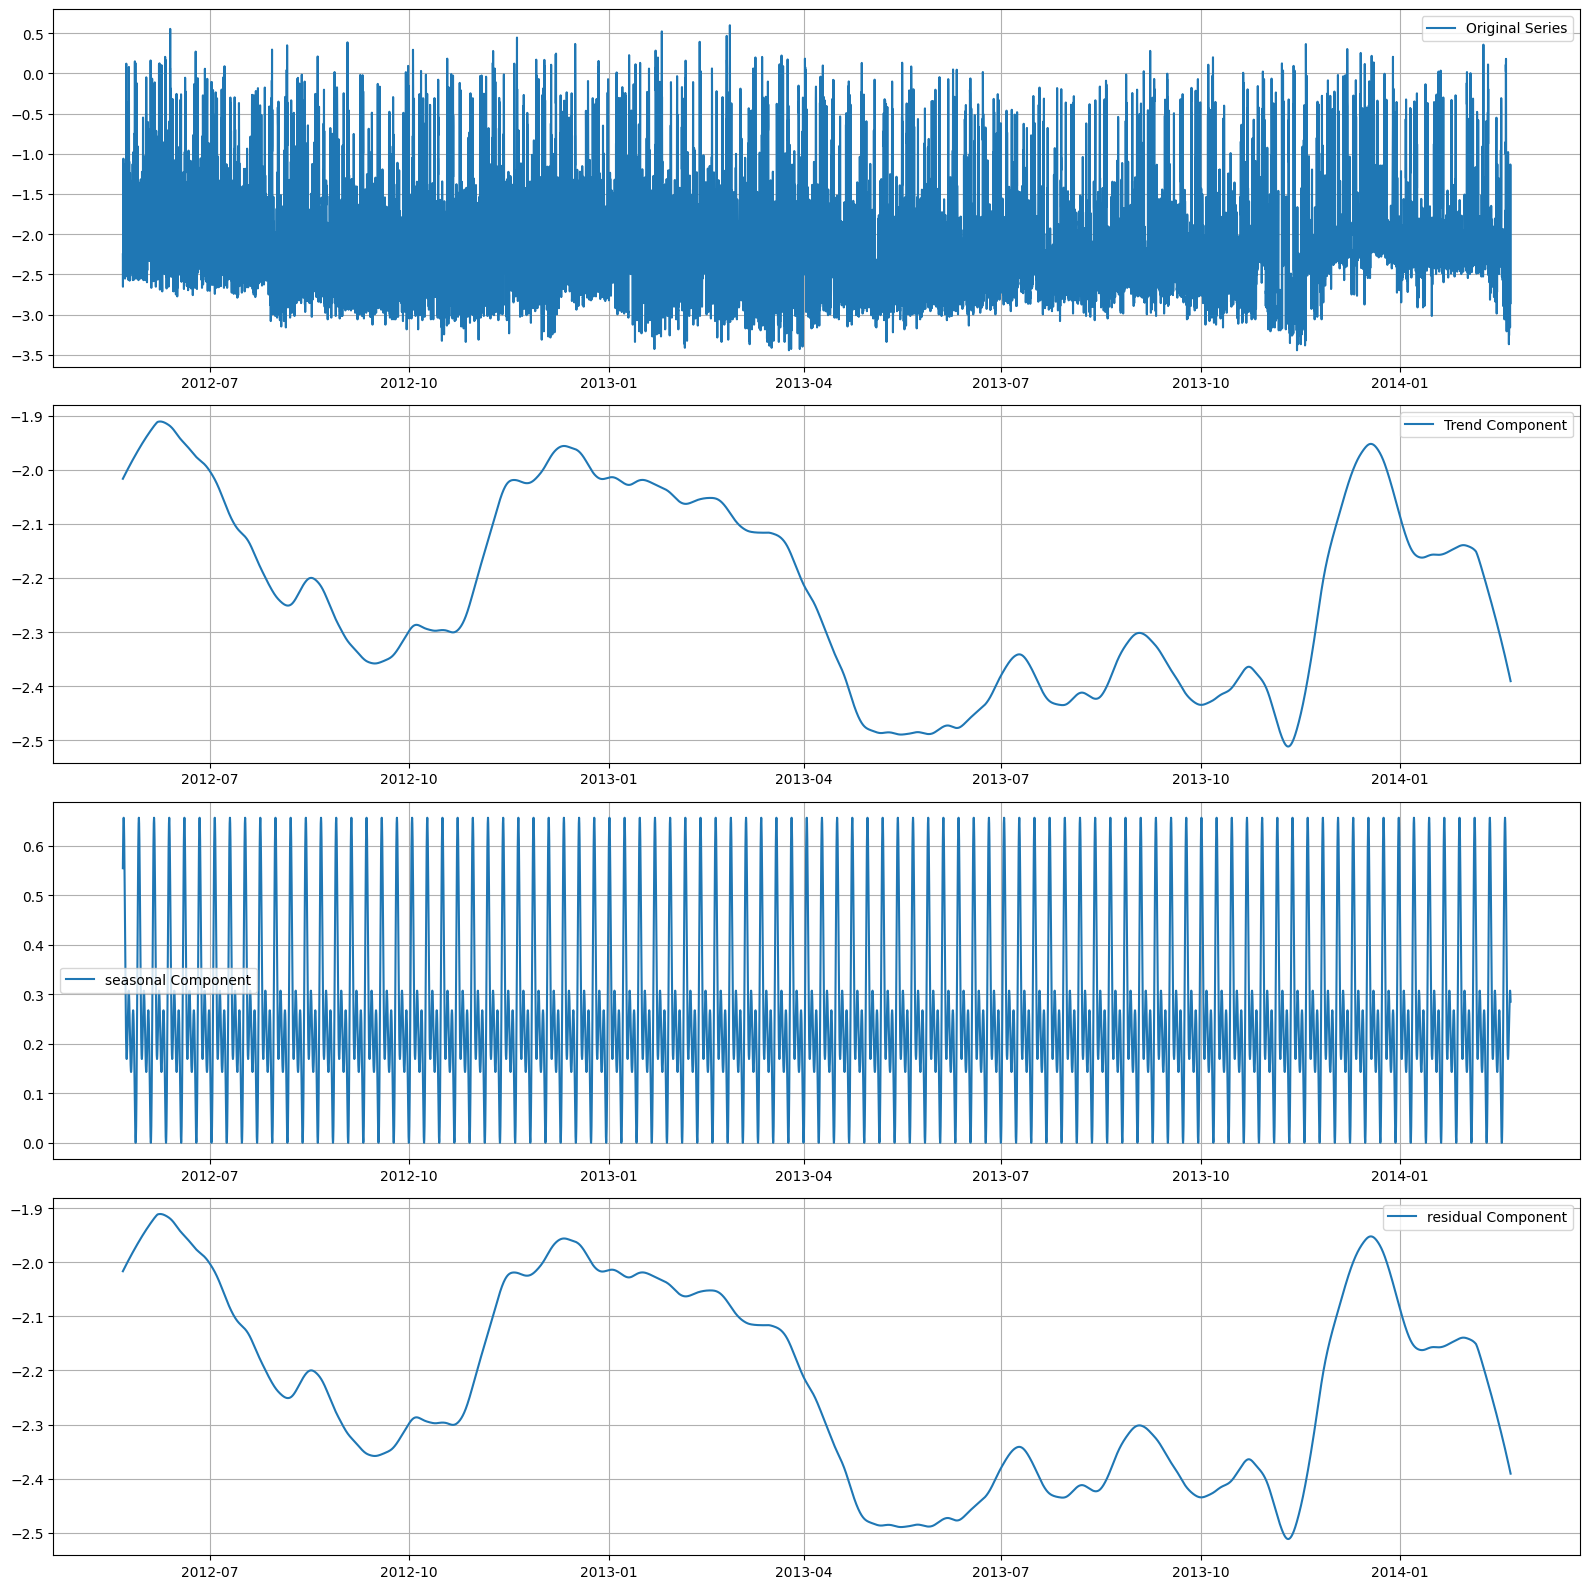

In [21]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

trend = lowess(hourly_df['log_energy_consumption'] , range(len(hourly_df)), frac=0.05)[:, 1]
detrended_series = hourly_df['log_energy_consumption'] - trend

time = np.arange(len(hourly_df['log_energy_consumption'] ))
seasonal = np.zeros_like(hourly_df['log_energy_consumption'] )
for i in range(1, 3+ 1):
    seasonal += (np.sin(2 * np.pi * i * time / (24*7)) +
                np.cos(2 * np.pi * i * time / (24*7)))

seasonal = (seasonal - seasonal.min()) / (seasonal.max() - seasonal.min())
seasonal = seasonal * detrended_series.std()

residual = detrended_series - seasonal
trend = pd.Series(index=hourly_df.index, data=trend)
seasonal = pd.Series(index=hourly_df.index, data=seasonal)
residual = pd.Series(index=hourly_df.index, data=residual)

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

axs[0].plot(hourly_df.index, hourly_df['log_energy_consumption'], label='Original Series')


axs[1].plot(hourly_df.index, trend, label='Trend Component')
axs[2].plot(hourly_df.index, seasonal, label='seasonal Component')
axs[3].plot(hourly_df.index, trend, label='residual Component')

for ax in axs:
    ax.legend()
    ax.grid()
fig.tight_layout()

In [22]:
hourly_df['log_energy_consumption_decomposed'] = hourly_df['log_energy_consumption'] -trend -seasonal

In [23]:
from statsmodels.tsa.stattools import adfuller, kpss

adfullers_test, adf_pval , _, __, ___, ____= adfuller(hourly_df['log_energy_consumption_decomposed'])
kpss_test, kpss_pval, _, __ = kpss(hourly_df['log_energy_consumption_decomposed'])

if adf_pval < 0.05:
  print("pValue: ", adf_pval)
  print('The series is stationary')
else:
  print('The series is not stationary')

if kpss_pval < 0.05:
  print('The series is not stationary')
else:
  print("pValue: ", kpss_pval)
  print('The series is stationary')

pValue:  0.0
The series is stationary
pValue:  0.1
The series is stationary


<ipython-input-23-07d637bc3a5a>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test, kpss_pval, _, __ = kpss(hourly_df['log_energy_consumption_decomposed'])


### here after decomposition data now is stationary so we can use ml models and get a good predictions

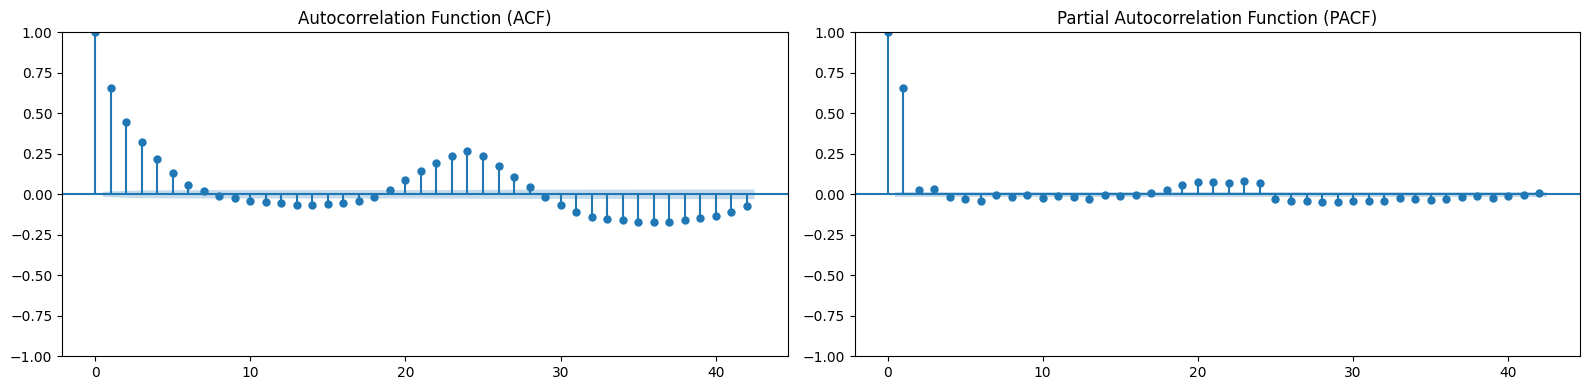

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(hourly_df['log_energy_consumption_decomposed'], ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(hourly_df['log_energy_consumption_decomposed'], ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### After visualize the autocorrelation and PACF i finf thet it correlated using 2 lags

### First Approach : Using Delay Embedding with Two Lags

In [25]:
tau = 1
hourly_df['Lag_1'] = hourly_df['log_energy_consumption_decomposed'].shift(tau)
hourly_df['Lag_2'] = hourly_df['Lag_1'].shift(tau)

hourly_df.head()

year  month  week  day  hour  energy_consumption  \
timestamp                                                               
2012-05-22 00:00:00  2012      5    21   22     0              0.1055   
2012-05-22 01:00:00  2012      5    21   22     1              0.0705   
2012-05-22 02:00:00  2012      5    21   22     2              0.0945   
2012-05-22 03:00:00  2012      5    21   22     3              0.0815   
2012-05-22 04:00:00  2012      5    21   22     4              0.0780   

                     log_energy_consumption  \
timestamp                                     
2012-05-22 00:00:00               -2.249044   
2012-05-22 01:00:00               -2.652143   
2012-05-22 02:00:00               -2.359155   
2012-05-22 03:00:00               -2.507152   
2012-05-22 04:00:00               -2.551046   

                     log_energy_consumption_decomposed     Lag_1     Lag_2  
timestamp                                                                   
2012-05-22 00:00:00                          -0.786841       NaN       NaN  
2012-05-22 01:00:00                          -1.210912 -0.786841       NaN  
2012-05-22 02:00:00                          -0.936841 -1.210912 -0.786841  
2012-05-22 03:00:00                          -1.101547 -0.936841 -1.210912  
2012-05-22 04:00:00                          -1.159813 -1.101547 -0.936841

### Using Random Forest Algorithm Without Bootstrap

In [26]:
from sklearn.ensemble import RandomForestRegressor
X = hourly_df[['Lag_1', 'Lag_2']]
y = hourly_df['log_energy_consumption_decomposed']

rf_dt_ds_model = RandomForestRegressor(n_estimators=100, bootstrap=False)
rf_dt_ds_model.fit(X, y)

RandomForestRegressor(bootstrap=False)

In [27]:
hourly_df['y_hat_rf'] = rf_dt_ds_model.predict(X) + trend + seasonal

In [28]:
hourly_df

year  month  week  day  hour  energy_consumption  \
timestamp                                                               
2012-05-22 00:00:00  2012      5    21   22     0              0.1055   
2012-05-22 01:00:00  2012      5    21   22     1              0.0705   
2012-05-22 02:00:00  2012      5    21   22     2              0.0945   
2012-05-22 03:00:00  2012      5    21   22     3              0.0815   
2012-05-22 04:00:00  2012      5    21   22     4              0.0780   
...                   ...    ...   ...  ...   ...                 ...   
2014-02-20 19:00:00  2014      2     8   20    19              0.2085   
2014-02-20 20:00:00  2014      2     8   20    20              0.3220   
2014-02-20 21:00:00  2014      2     8   20    21              0.1380   
2014-02-20 22:00:00  2014      2     8   20    22              0.1120   
2014-02-20 23:00:00  2014      2     8   20    23              0.0575   

                     log_energy_consumption  \
timestamp                                     
2012-05-22 00:00:00               -2.249044   
2012-05-22 01:00:00               -2.652143   
2012-05-22 02:00:00               -2.359155   
2012-05-22 03:00:00               -2.507152   
2012-05-22 04:00:00               -2.551046   
...                                     ...   
2014-02-20 19:00:00               -1.567816   
2014-02-20 20:00:00               -1.133204   
2014-02-20 21:00:00               -1.980502   
2014-02-20 22:00:00               -2.189256   
2014-02-20 23:00:00               -2.855970   

                     log_energy_consumption_decomposed     Lag_1     Lag_2  \
timestamp                                                                    
2012-05-22 00:00:00                          -0.786841       NaN       NaN   
2012-05-22 01:00:00                          -1.210912 -0.786841       NaN   
2012-05-22 02:00:00                          -0.936841 -1.210912 -0.786841   
2012-05-22 03:00:00                          -1.101547 -0.936841 -1.210912   
2012-05-22 04:00:00                          -1.159813 -1.101547 -0.936841   
...                                                ...       ...       ...   
2014-02-20 19:00:00                           0.515721 -0.135711 -1.079206   
2014-02-20 20:00:00                           0.954334  0.515721 -0.135711   
2014-02-20 21:00:00                           0.112148  0.954334  0.515721   
2014-02-20 22:00:00                          -0.090449  0.112148  0.954334   
2014-02-20 23:00:00                          -0.750039 -0.090449  0.112148   

                     y_hat_rf  
timestamp                      
2012-05-22 00:00:00 -2.229638  
2012-05-22 01:00:00 -2.652143  
2012-05-22 02:00:00 -2.359155  
2012-05-22 03:00:00 -2.507152  
2012-05-22 04:00:00 -2.551046  
...                       ...  
2014-02-20 19:00:00 -1.567816  
2014-02-20 20:00:00 -1.133204  
2014-02-20 21:00:00 -1.980502  
2014-02-20 22:00:00 -2.189256  
2014-02-20 23:00:00 -2.855970  

[15360 rows x 11 columns]

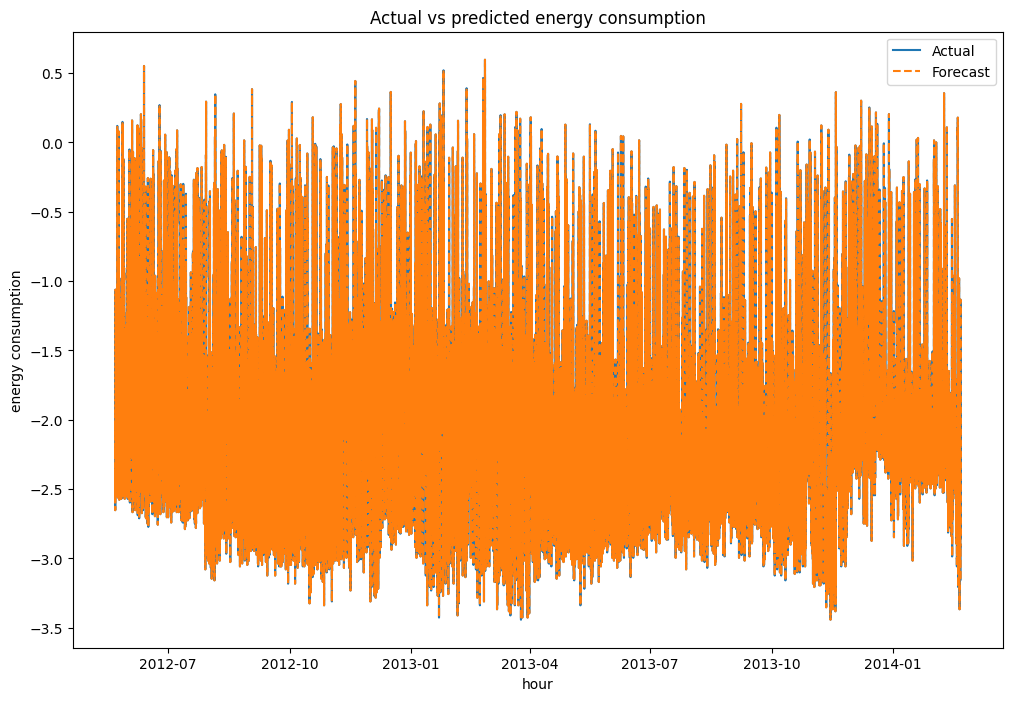

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(hourly_df.index, hourly_df['log_energy_consumption'], label='Actual')
ax.plot(hourly_df.index, hourly_df['y_hat_rf'], label='Forecast', linestyle='--')
ax.set_title('Actual vs predicted energy consumption')
ax.set_xlabel('hour')
ax.set_ylabel('energy consumption')
ax.legend()
plt.show()

### The fit (predictions) is so good because we make a good analysis :
1- log variance to make the data stationary

2- decomposition using Fourier Decomposition making the data stationary

3- find the effected Lags using PACF

4- making the Delay Embedding  

3- using thr Random Forest Algo without bootstrap

4- finally add the seasonality and decomposition again  

In [30]:
h = 168
def forecast_future_ds(model, data, trend,seasonal, steps=168, freq='h'):
    # Starting with the last known lag values
    last_lag1 = data['Lag_1'].iloc[-1]
    last_lag2 = data['Lag_2'].iloc[-1]

    # To store future predictions
    future_predictions = []

    # Fill NaN values in the trend and seasonal components, if any, at the end
    trend =trend.dropna()
    seasonal = seasonal.dropna()

    # Assuming the seasonal cycle is 12 months, we can repeat the last known cycle
    seasonal_cycle = seasonal[-168:].tolist()

    # We can take the last known trend change to extrapolate the trend
    trend_diff = trend.iloc[-1] - trend.iloc[-2]
    last_known_trend = trend.iloc[-1]

    for step in range(steps):
        # Format the input with the correct column names
        input_df = pd.DataFrame([[last_lag1, last_lag2]], columns=['Lag_1', 'Lag_2'])

        # Predict the next value
        next_value_pred = model.predict(input_df)[0]

        # Update lag values
        last_lag2 = last_lag1
        last_lag1 = next_value_pred

        # Add back the trend and seasonal components
        # Extrapolate the trend
        next_trend = last_known_trend + trend_diff * (step + 1)

        # Use the corresponding seasonal component
        next_seasonal = seasonal_cycle[step % 168]

        next_value_pred += next_trend + next_seasonal

        future_predictions.append(next_value_pred)

    # Create a date range for the future predictions
    last_date = data.index[-1]


    # Generate future dates
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(1, freq),
        periods=steps,
        freq=freq
    )
    #future_dates = pd.date_range(start=last_date + pd.DateOffset(1, freq), periods=h, freq=freq)
    future_df = pd.DataFrame(index=future_dates, data=future_predictions, columns=["RF_bootstrapFalse_forecast"])


    return future_df

In [31]:
future_df = forecast_future_ds(rf_dt_ds_model, hourly_df,  trend , seasonal , h, freq='H')

<ipython-input-30-f8aa7761d9db>:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(


In [32]:
future_df

RF_bootstrapFalse_forecast
2014-02-21 00:00:00                   -2.863964
2014-02-21 01:00:00                   -2.850040
2014-02-21 02:00:00                   -1.982232
2014-02-21 03:00:00                   -2.328068
2014-02-21 04:00:00                   -1.923140
...                                         ...
2014-02-27 19:00:00                   -1.115876
2014-02-27 20:00:00                   -2.007652
2014-02-27 21:00:00                   -3.175485
2014-02-27 22:00:00                   -1.483576
2014-02-27 23:00:00                   -0.399830

[168 rows x 1 columns]

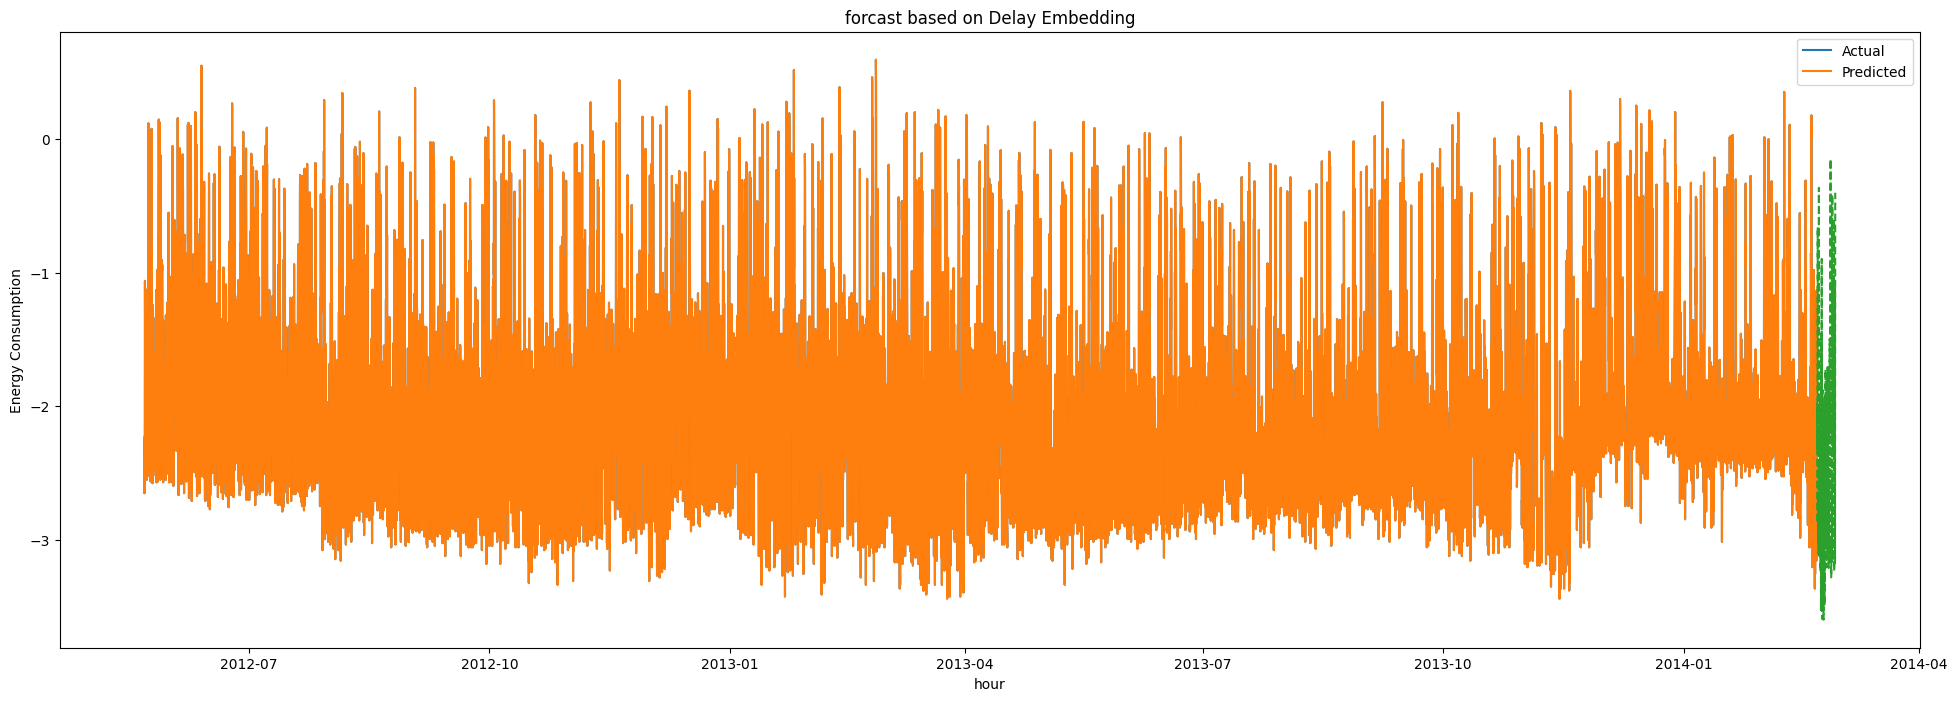

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(24, 8))

ax.plot(hourly_df.index, hourly_df['log_energy_consumption'], label='Actual')
ax.plot(hourly_df.index, hourly_df['y_hat_rf'], label='Predicted')
ax.plot(future_df.index, future_df['RF_bootstrapFalse_forecast'],linestyle='--')

ax.set_title(f'forcast based on Delay Embedding')
ax.set_xlabel('hour')
ax.set_ylabel('Energy Consumption')
ax.legend()
plt.show()

### Second Approach : Using Temporal Embedding

In [34]:
import numpy as np

def add_cyclic_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)

    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)

    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    return df

hourly_df_full_embedding = add_cyclic_features(hourly_df)

In [35]:
hourly_df_full_embedding

year  month  week  day  hour  energy_consumption  \
timestamp                                                               
2012-05-22 00:00:00  2012      5    21   22     0              0.1055   
2012-05-22 01:00:00  2012      5    21   22     1              0.0705   
2012-05-22 02:00:00  2012      5    21   22     2              0.0945   
2012-05-22 03:00:00  2012      5    21   22     3              0.0815   
2012-05-22 04:00:00  2012      5    21   22     4              0.0780   
...                   ...    ...   ...  ...   ...                 ...   
2014-02-20 19:00:00  2014      2     8   20    19              0.2085   
2014-02-20 20:00:00  2014      2     8   20    20              0.3220   
2014-02-20 21:00:00  2014      2     8   20    21              0.1380   
2014-02-20 22:00:00  2014      2     8   20    22              0.1120   
2014-02-20 23:00:00  2014      2     8   20    23              0.0575   

                     log_energy_consumption  \
timestamp                                     
2012-05-22 00:00:00               -2.249044   
2012-05-22 01:00:00               -2.652143   
2012-05-22 02:00:00               -2.359155   
2012-05-22 03:00:00               -2.507152   
2012-05-22 04:00:00               -2.551046   
...                                     ...   
2014-02-20 19:00:00               -1.567816   
2014-02-20 20:00:00               -1.133204   
2014-02-20 21:00:00               -1.980502   
2014-02-20 22:00:00               -2.189256   
2014-02-20 23:00:00               -2.855970   

                     log_energy_consumption_decomposed     Lag_1     Lag_2  \
timestamp                                                                    
2012-05-22 00:00:00                          -0.786841       NaN       NaN   
2012-05-22 01:00:00                          -1.210912 -0.786841       NaN   
2012-05-22 02:00:00                          -0.936841 -1.210912 -0.786841   
2012-05-22 03:00:00                          -1.101547 -0.936841 -1.210912   
2012-05-22 04:00:00                          -1.159813 -1.101547 -0.936841   
...                                                ...       ...       ...   
2014-02-20 19:00:00                           0.515721 -0.135711 -1.079206   
2014-02-20 20:00:00                           0.954334  0.515721 -0.135711   
2014-02-20 21:00:00                           0.112148  0.954334  0.515721   
2014-02-20 22:00:00                          -0.090449  0.112148  0.954334   
2014-02-20 23:00:00                          -0.750039 -0.090449  0.112148   

                     y_hat_rf  hour_sin   day_sin  week_sin  month_sin  
timestamp                                                               
2012-05-22 00:00:00 -2.229638  0.000000 -0.968077  0.568065   0.500000  
2012-05-22 01:00:00 -2.652143  0.258819 -0.968077  0.568065   0.500000  
2012-05-22 02:00:00 -2.359155  0.500000 -0.968077  0.568065   0.500000  
2012-05-22 03:00:00 -2.507152  0.707107 -0.968077  0.568065   0.500000  
2012-05-22 04:00:00 -2.551046  0.866025 -0.968077  0.568065   0.500000  
...                       ...       ...       ...       ...        ...  
2014-02-20 19:00:00 -1.567816 -0.965926 -0.790776  0.822984   0.866025  
2014-02-20 20:00:00 -1.133204 -0.866025 -0.790776  0.822984   0.866025  
2014-02-20 21:00:00 -1.980502 -0.707107 -0.790776  0.822984   0.866025  
2014-02-20 22:00:00 -2.189256 -0.500000 -0.790776  0.822984   0.866025  
2014-02-20 23:00:00 -2.855970 -0.258819 -0.790776  0.822984   0.866025  

[15360 rows x 15 columns]

In [36]:
from sklearn.ensemble import RandomForestRegressor
X = hourly_df_full_embedding[['hour_sin', 'day_sin', 'week_sin' , 'month_sin']]
y = hourly_df_full_embedding['log_energy_consumption_decomposed']

rf_dt_ds_model_Temporal = RandomForestRegressor(n_estimators=100, bootstrap=False)
rf_dt_ds_model_Temporal.fit(X, y)

RandomForestRegressor(bootstrap=False)

In [37]:
hourly_df_full_embedding['y_hat_rf_temporal'] = rf_dt_ds_model_Temporal.predict(X) + trend + seasonal

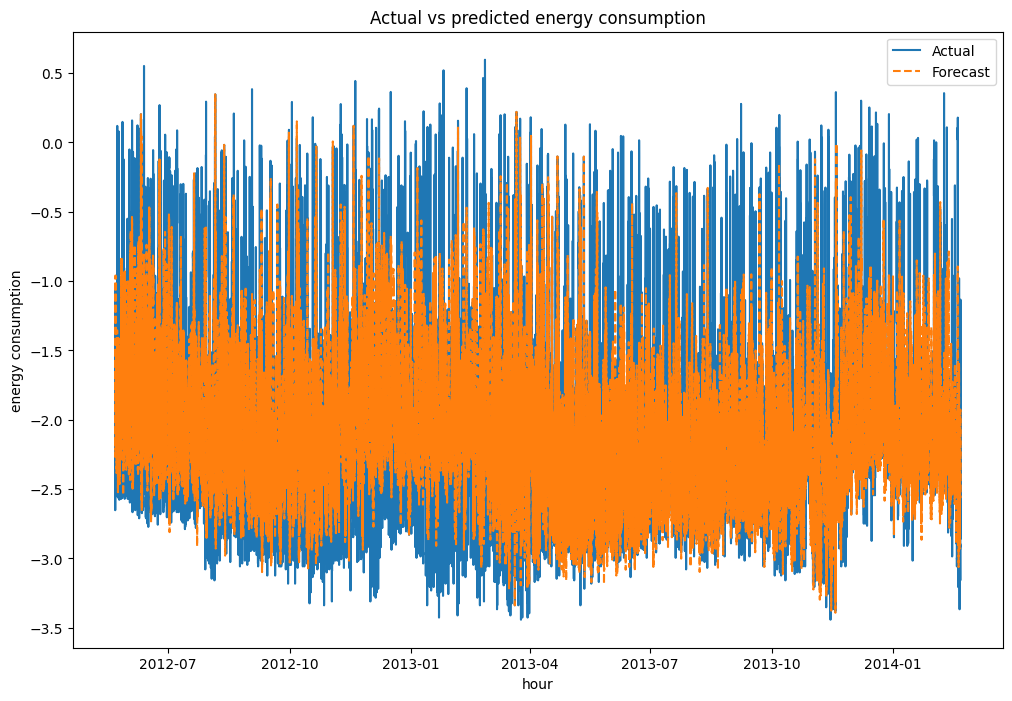

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(hourly_df_full_embedding.index, hourly_df_full_embedding['log_energy_consumption'], label='Actual')
ax.plot(hourly_df_full_embedding.index, hourly_df_full_embedding['y_hat_rf_temporal'], label='Forecast', linestyle='--')
ax.set_title('Actual vs predicted energy consumption')
ax.set_xlabel('hour')
ax.set_ylabel('energy consumption')
ax.legend()
plt.show()

### using only the Temporal Embedding So the predictions are not good because no correlation be considered in this approach

### Forcasting using Temporal embedding

In [79]:
def forecast_future_temporal(model, last_known_data, trend, seasonal, steps=168):
    """Forecast future values with temporal features, trend, and seasonality."""
    forecasts = []
    timestamps = []

    # Extract initial time components
    hour = int(last_known_data['hour'])
    day = int(last_known_data['day'])
    week = int(last_known_data['week'])
    month = int(last_known_data['month'])

    # Get last timestamp from historical data
    last_timestamp = hourly_df_full_embedding.index[-1]

    # Clean trend and seasonal
    trend = trend.dropna()
    seasonal = seasonal.dropna()

    # Prepare seasonal cycle (e.g., 168 hours = 1 week if hourly)
    seasonal_cycle = seasonal[-168:].tolist()

    # Compute trend difference and get the last trend value
    trend_diff = trend.iloc[-1] - trend.iloc[-2]
    last_known_trend = trend.iloc[-1]

    for step in range(steps):
        # Cyclical temporal features
        hour_sin = np.sin(2 * np.pi * hour / 24)
        day_sin = np.sin(2 * np.pi * day / 31)
        week_sin = np.sin(2 * np.pi * week / 52)
        month_sin = np.sin(2 * np.pi * month / 12)

        # Build features DataFrame
        features_df = pd.DataFrame({
            'hour_sin': [hour_sin],
            'day_sin': [day_sin],
            'week_sin': [week_sin],
            'month_sin': [month_sin]
        })

        # Predict base value
        base_pred = model.predict(features_df)[0]

        # Add trend and seasonal components
        current_trend = last_known_trend + trend_diff * (step + 1)
        current_seasonal = seasonal_cycle[step % 168]
        full_prediction = base_pred + current_trend + current_seasonal

        forecasts.append(full_prediction)

        # Generate timestamp
        pred_time = last_timestamp + pd.Timedelta(hours=step + 1)
        timestamps.append(pred_time)

        # Update time
        hour += 1
        if hour >= 24:
            hour = 0
            day += 1
            if day > 31:
                day = 1
                month += 1
                if month > 12:
                    month = 1
            week += 1
            if week > 52:
                week = 1

    # Create result DataFrame
    forecast_df = pd.DataFrame(
        forecasts,
        index=pd.DatetimeIndex(timestamps),
        columns=["forecasted_consumption"]
    )

    return forecast_df



# Get last known data point
last_known_data = hourly_df_full_embedding.iloc[-1][['hour', 'day', 'week', 'month', 'hour_sin', 'day_sin', 'week_sin', 'month_sin']].copy()

# Generate forecasts
future_predictions = forecast_future_temporal(rf_dt_ds_model_Temporal, last_known_data, trend, seasonal, steps=169)

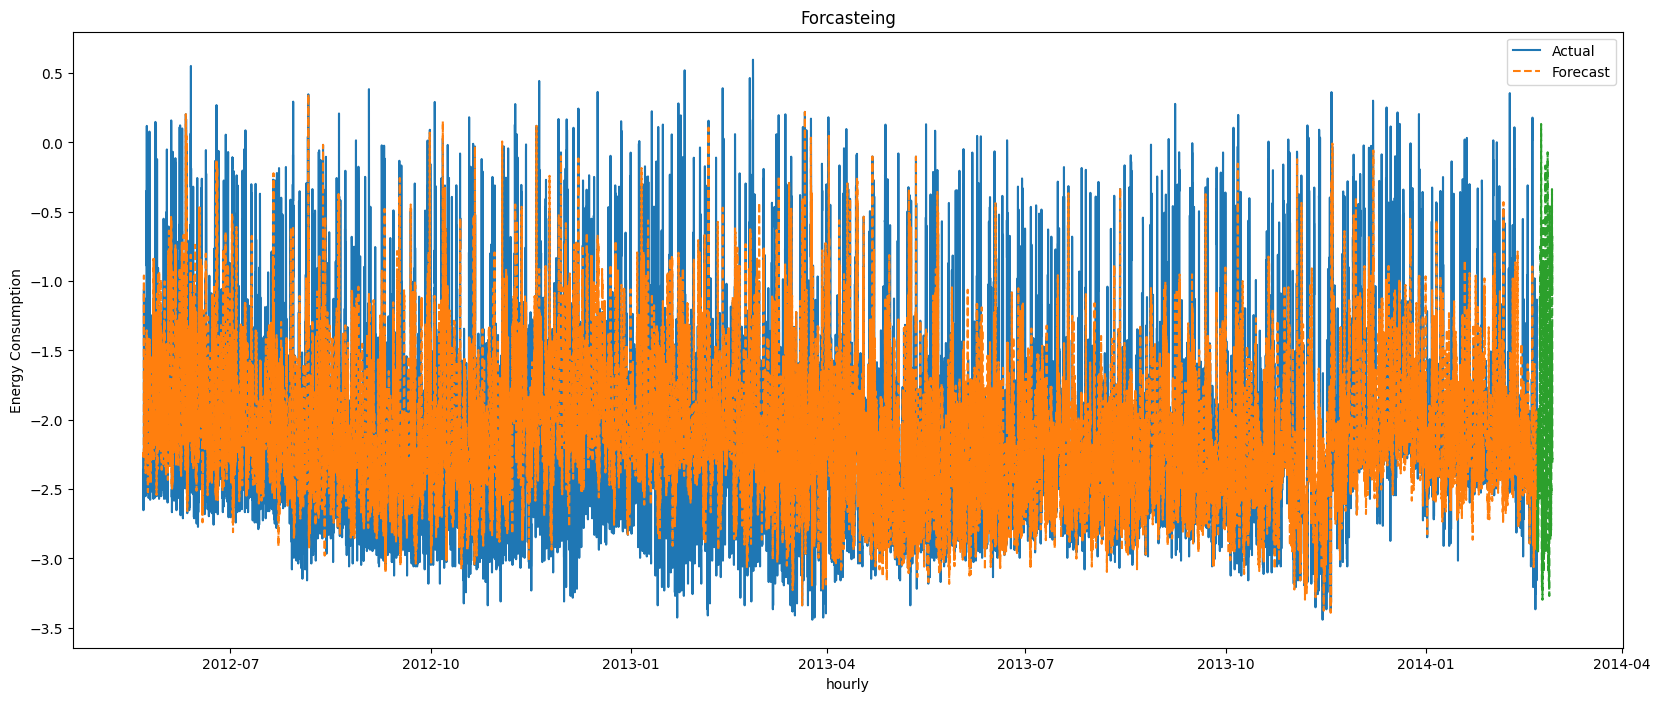

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(hourly_df_full_embedding.index, hourly_df_full_embedding['log_energy_consumption'], label='Actual')
ax.plot(hourly_df_full_embedding.index, hourly_df_full_embedding['y_hat_rf_temporal'], label='Forecast', linestyle='--')
future_predictions
ax.plot(future_predictions.index, future_predictions['forecasted_consumption'],linestyle='--')

ax.set_title(f'Forcasteing')
ax.set_xlabel('hourly')
ax.set_ylabel('Energy Consumption')
ax.legend()
plt.show()

### Third Approach : Using Combination between Delay Embedding with Two Lags and Temporal Embedding

In [81]:
from sklearn.ensemble import RandomForestRegressor
X = hourly_df_full_embedding[['Lag_1', 'Lag_2','hour_sin', 'day_sin', 'week_sin' , 'month_sin']]
y = hourly_df_full_embedding['log_energy_consumption_decomposed']

rf_dt_ds_model_Temporal_Delay = RandomForestRegressor(n_estimators=100, bootstrap=False)
rf_dt_ds_model_Temporal_Delay.fit(X, y)

RandomForestRegressor(bootstrap=False)

In [82]:
hourly_df_full_embedding['y_hat_rf_temporal_delay'] = rf_dt_ds_model_Temporal_Delay.predict(X) + trend + seasonal

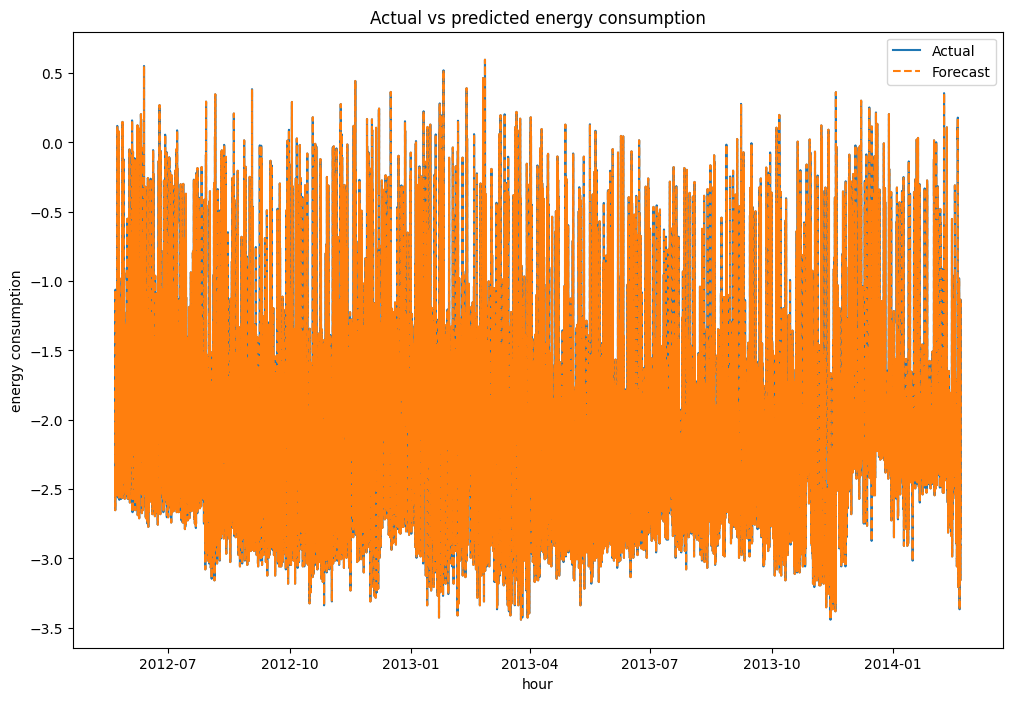

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(hourly_df_full_embedding.index, hourly_df_full_embedding['log_energy_consumption'], label='Actual')
ax.plot(hourly_df_full_embedding.index, hourly_df_full_embedding['y_hat_rf_temporal_delay'], label='Forecast', linestyle='--')
ax.set_title('Actual vs predicted energy consumption')
ax.set_xlabel('hour')
ax.set_ylabel('energy consumption')
ax.legend()
plt.show()

In [84]:
def combined_forecast(model, data, trend, seasonal, last_known_data, steps=168, freq='H'):
    """
    Combined forecast using both lag features and temporal features with proper time progression

    Parameters:
    - model: Trained forecasting model
    - data: Historical data with lag features
    - trend: Trend component from decomposition
    - seasonal: Seasonal component from decomposition
    - last_known_data: Last row of data with temporal features
    - steps: Number of steps to forecast
    - freq: Frequency of data ('H' for hourly)

    Returns:
    - DataFrame with forecasts and proper DateTimeIndex
    """
    # Initialize storage
    forecasts = []
    timestamps = []

    # Get last timestamp
    last_timestamp = data.index[-1]

    # Initialize lag values
    last_lag1 = data['Lag_1'].iloc[-1]
    last_lag2 = data['Lag_2'].iloc[-1]

    # Initialize time components
    hour = int(last_known_data['hour'])
    day = int(last_known_data['day'])
    week = int(last_known_data['week'])
    month = int(last_known_data['month'])

    # Prepare components
    trend = trend.dropna()
    seasonal = seasonal.dropna()
    seasonal_cycle = seasonal[-168:].tolist()  # Weekly seasonality for hourly data
    trend_diff = trend.iloc[-1] - trend.iloc[-2]
    last_known_trend = trend.iloc[-1]

    for step in range(steps):
        # =============================================
        # 1. Prepare Features
        # =============================================
        # Temporal features
        hour_sin = np.sin(2 * np.pi * hour / 24)
        day_sin = np.sin(2 * np.pi * day / 31)
        week_sin = np.sin(2 * np.pi * week / 52)
        month_sin = np.sin(2 * np.pi * month / 12)

        # Combine all features
        features = {
            'Lag_1': last_lag1,
            'Lag_2': last_lag2,
            'hour_sin': hour_sin,
            'day_sin': day_sin,
            'week_sin': week_sin,
            'month_sin': month_sin
        }

        # =============================================
        # 2. Make Prediction
        # =============================================
        # Convert to DataFrame with correct feature order
        input_df = pd.DataFrame([features], columns=['Lag_1', 'Lag_2', 'hour_sin', 'day_sin', 'week_sin', 'month_sin'])

        # Get base prediction
        base_pred = model.predict(input_df)[0]

        # Add components
        current_trend = last_known_trend + trend_diff * (step + 1)
        current_seasonal = seasonal_cycle[step % 168]
        full_pred = base_pred + current_trend + current_seasonal

        forecasts.append(full_pred)

        # =============================================
        # 3. Update State for Next Step
        # =============================================
        # Update lags (using the prediction before adding components)
        last_lag2, last_lag1 = last_lag1, base_pred

        # Update time
        hour += 1
        if hour >= 24:
            hour = 0
            day += 1
            if day > 31:
                day = 1
                month += 1
                if month > 12:
                    month = 1
            week += 1
            if week > 52:
                week = 1

        # Generate timestamp
        timestamps.append(last_timestamp + pd.Timedelta(hours=step+1))

    # Create result DataFrame
    forecast_df = pd.DataFrame(
        forecasts,
        index=pd.DatetimeIndex(timestamps),
        columns=['combined_forecast']
    )

    return forecast_df

# =============================================
# Usage Example
# =============================================
# Get last known data
last_known_data = hourly_df_full_embedding.iloc[-1][['hour', 'day', 'week', 'month', 'hour_sin', 'day_sin', 'week_sin', 'month_sin']].copy()

future_predictions = combined_forecast(rf_dt_ds_model_Temporal_Delay,hourly_df_full_embedding, trend, seasonal, last_known_data ,steps=169)

In [85]:
future_predictions

combined_forecast
2014-02-21 00:00:00          -2.863964
2014-02-21 01:00:00          -2.655549
2014-02-21 02:00:00          -2.660134
2014-02-21 03:00:00          -2.616801
2014-02-21 04:00:00          -2.530131
...                                ...
2014-02-27 20:00:00          -0.792291
2014-02-27 21:00:00          -0.266705
2014-02-27 22:00:00          -0.284143
2014-02-27 23:00:00          -1.331685
2014-02-28 00:00:00          -1.723831

[169 rows x 1 columns]

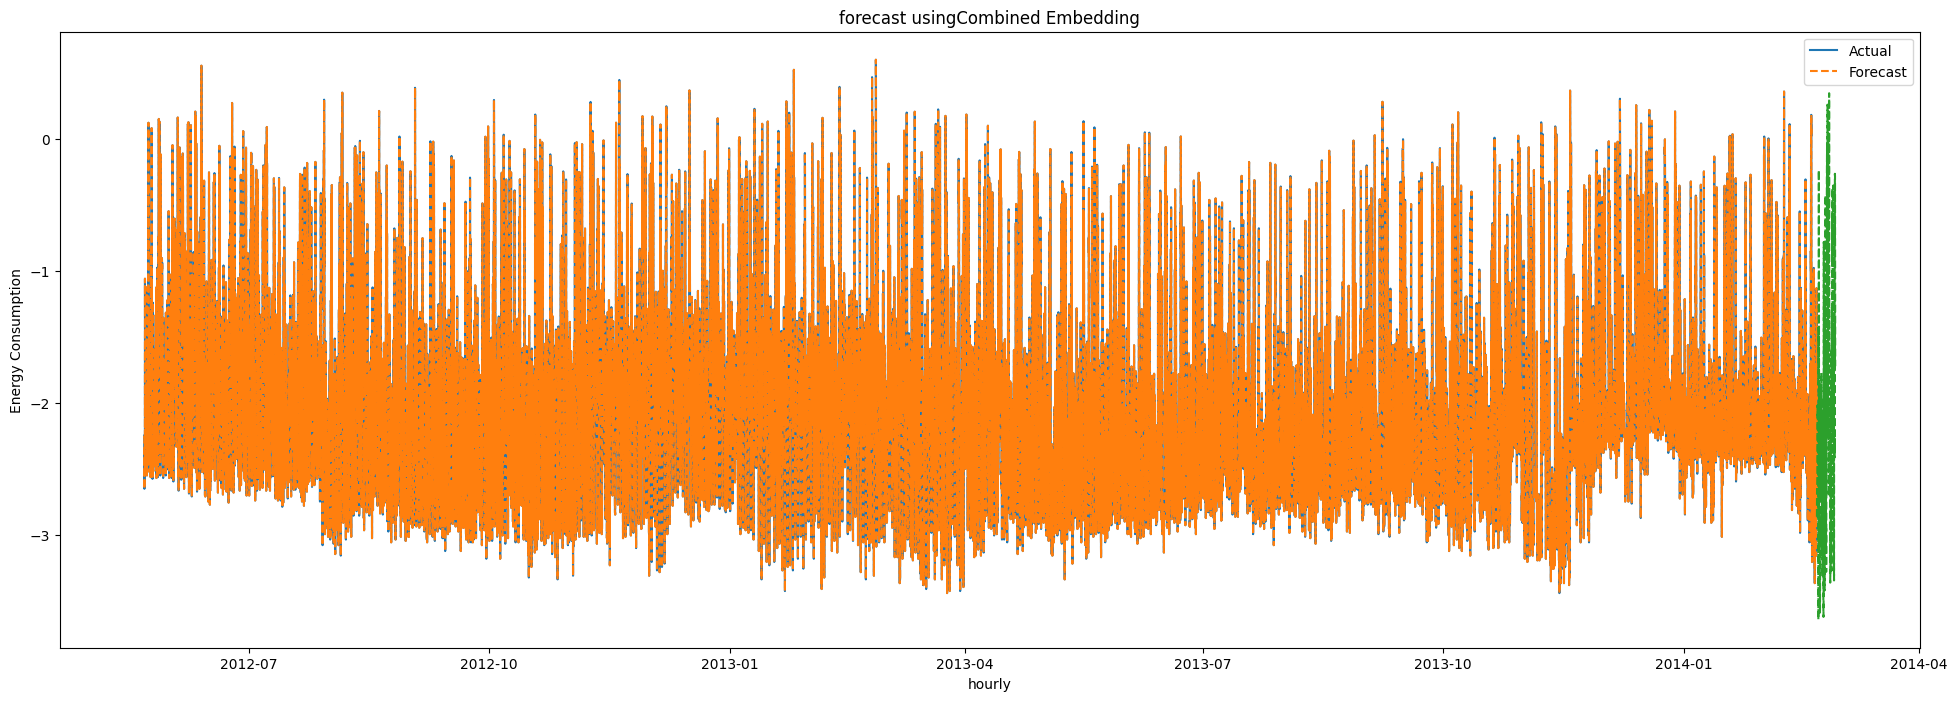

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(24, 8))

ax.plot(hourly_df_full_embedding.index, hourly_df_full_embedding['log_energy_consumption'], label='Actual')
ax.plot(hourly_df_full_embedding.index, hourly_df_full_embedding['y_hat_rf_temporal_delay'], label='Forecast', linestyle='--')
future_predictions
ax.plot(future_predictions.index, future_predictions['combined_forecast'],linestyle='--')

ax.set_title(f'forecast usingCombined Embedding')
ax.set_xlabel('hourly')
ax.set_ylabel('Energy Consumption')
ax.legend()
plt.show()

Combined :

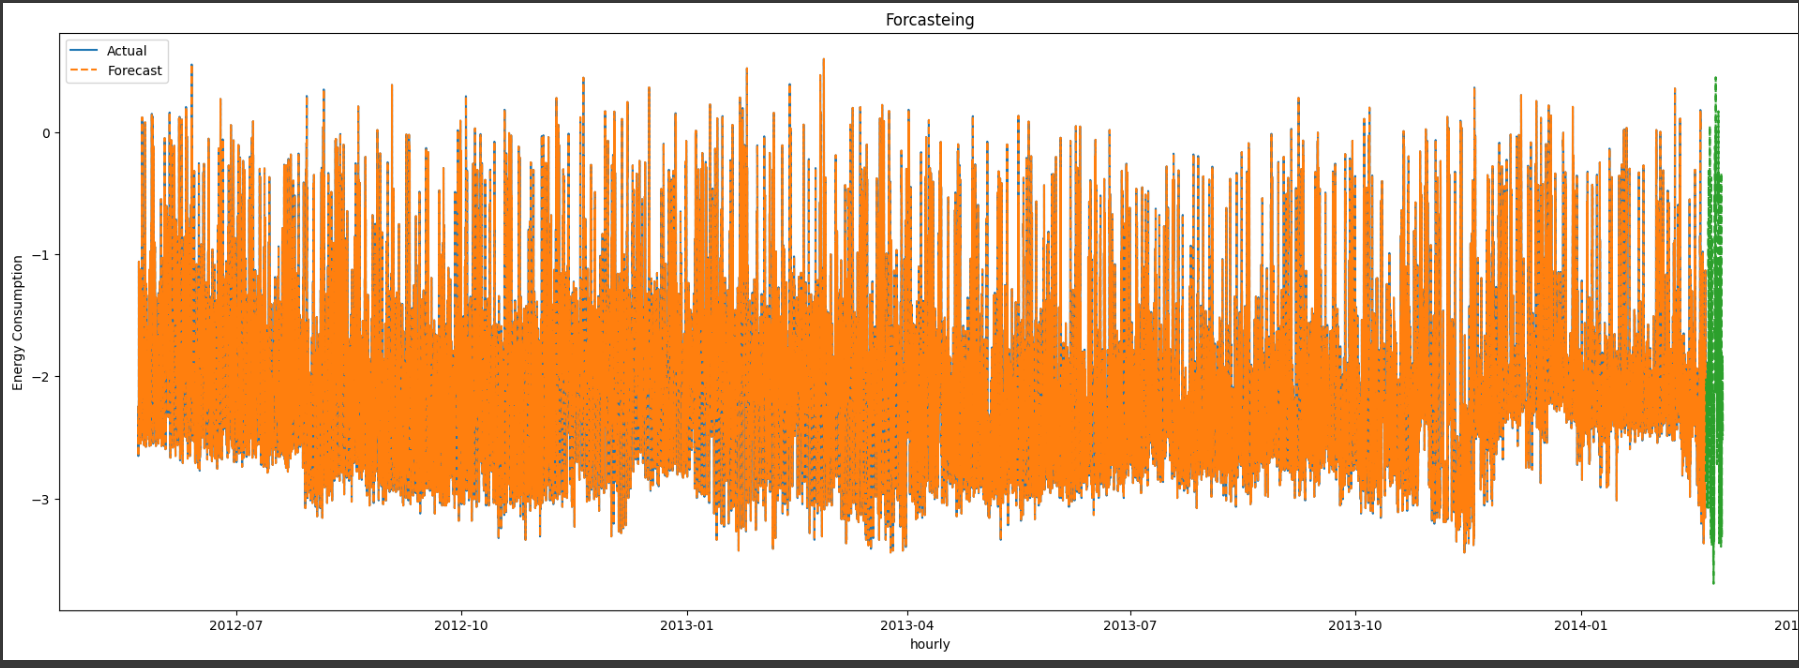

temoral :

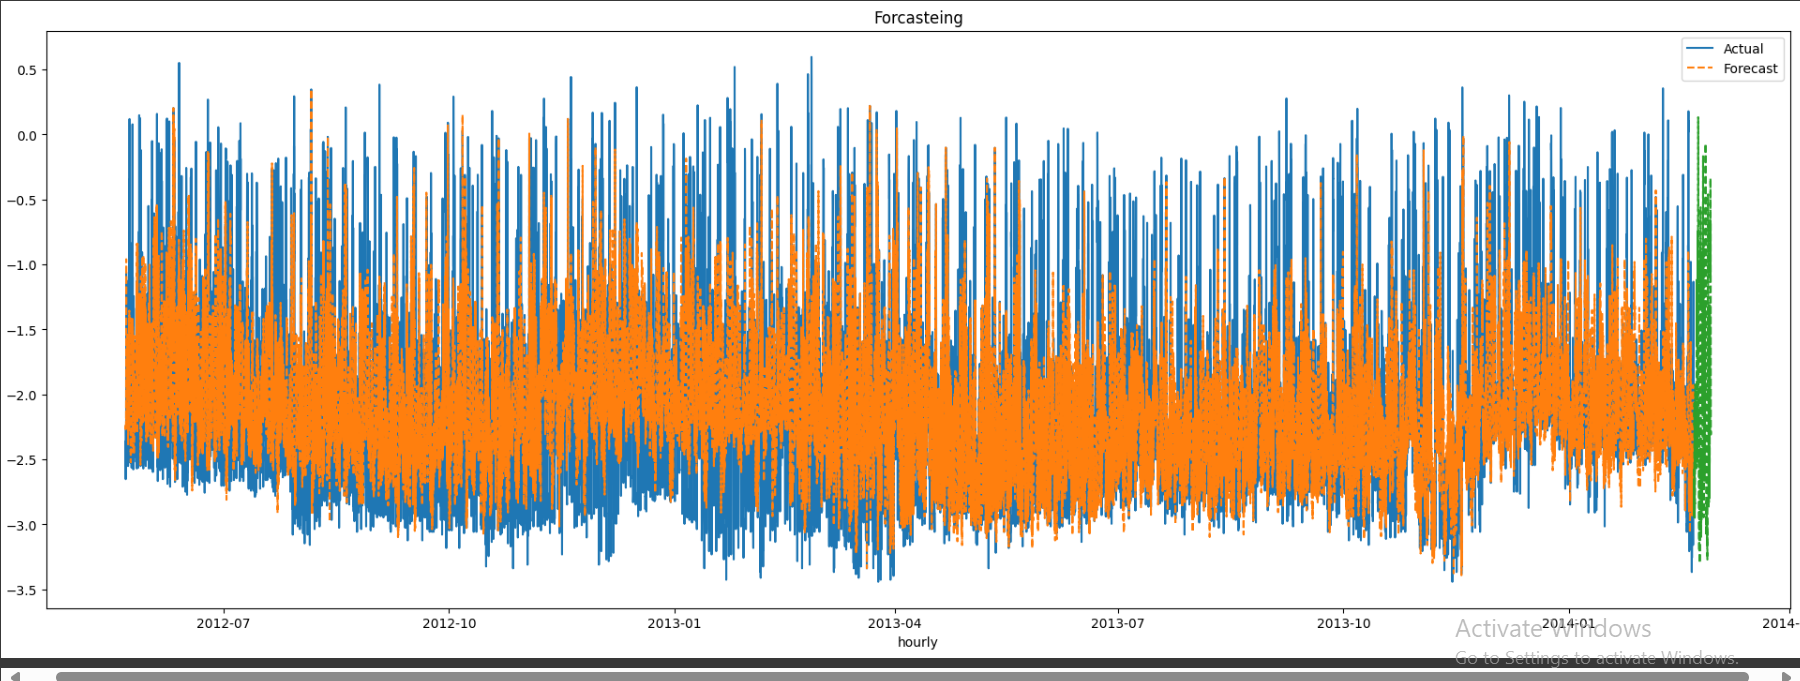

delay:

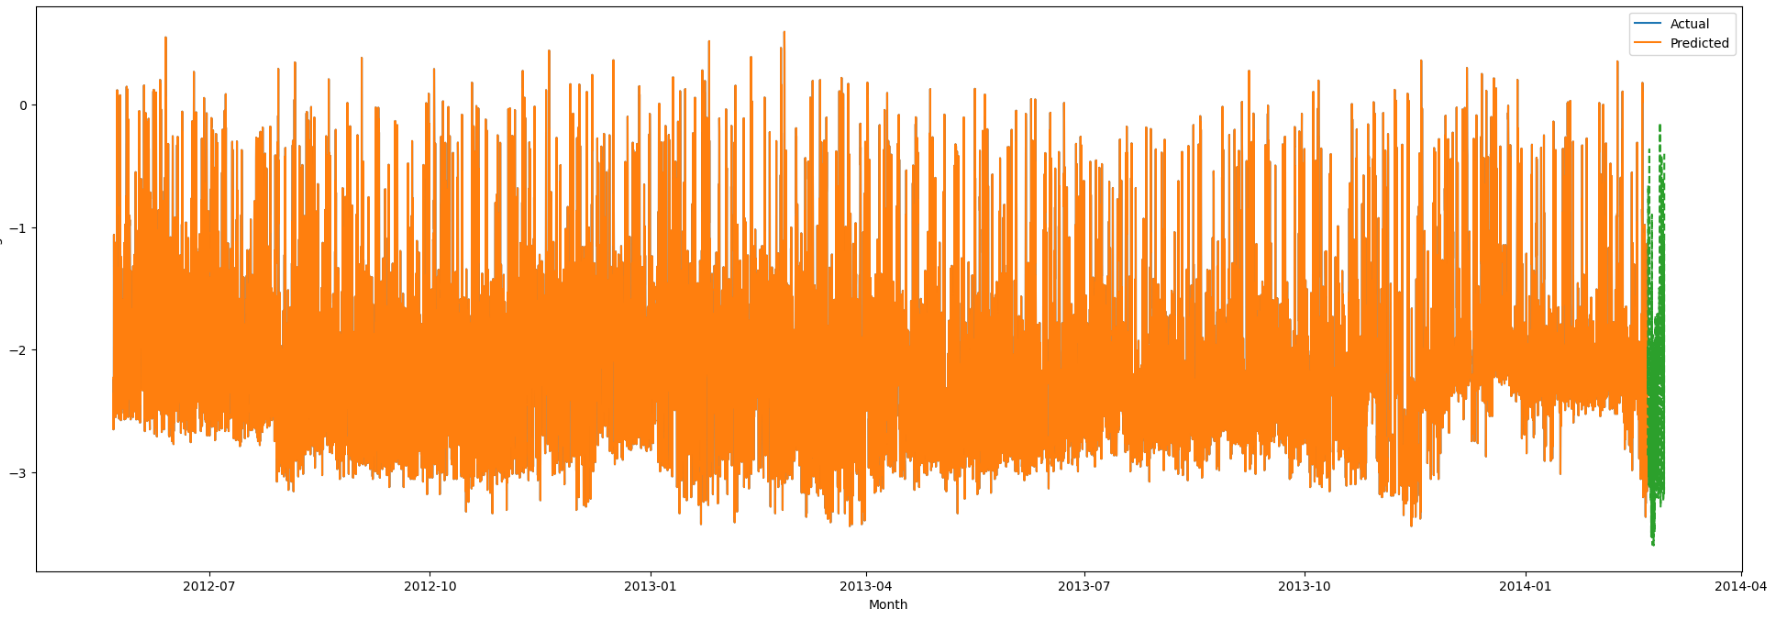

### It seems that the most significant technique without any errors in Delayed Embedding but The combined can be more general without overfit